# Tidal Modelling and Tagging

**What does this notebook do?** 

This notebooks demonstrates how to tidally tag remotely sensed imagery using an external tidal model so that images can be extracted or analysed by tidal stage (e.g. low or high tide). This tidal model ([OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html)) is used to produce datasets including the Intertidal Extents Model (ITEM), High-Low Tide Composites (HLTC), and the National Intertidal Digital Elevation Model (NIDEM).

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Author:** Robbi Bishop-Taylor

## Import modules

In [2]:
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')


## Import remotely-sensed time series data
Imports a time series of Landsat observations as a DEA `xarray` dataset, and extracts a list of timestamps based on the time and date of acquisition for each Landsat observation. These timestamps can then be used as one of the inputs to the [OSU Tidal Prediction Software (OTPS) tidal model](http://volkov.oce.orst.edu/tides/otps.html). The input data does not need to be from Landsat: any remotely-sensed imagery with timestamps and spatial coordinates provide enough data to run the tidal model. From [Sagar et al. 2015](https://www.sciencedirect.com/science/article/pii/S0034425717301591):

<div class="alert alert-info">
The OTPS TPX08 model [consists] of a multi-resolution bathymetric grid solution, with a 1/6° solution in the global open ocean, and a 1/30° local resolution solution to improve modelling in complex shallow water environments (Egbert and Erofeeva, 2010). The OTPS model is based on a system of linear partial differential equations, called Laplace's tidal equations, parametrised with nine harmonic tidal constituents. The model is fitted to track-averaged TOPEX/Poseidon altimeter data collected from 1992 to 2016 and Jason-1 (Poseidon 2) altimeter data from 2002 to 2013, enabling estimation of the tidal height and harmonic constituents at discrete temporal epochs and spatial locations (Egbert and Erofeeva, 2002).
</div>

In [21]:
# Set up analysis data query
lat, lon = -18.2066466248, 122.214634558
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 8000, x + 8000),
         'y': (y - 8000, y + 8000),         
         'crs': 'EPSG:3577',
         'time': ('2015-01-01', '2015-06-30')}

# Import data
data = dc.load(product = 'ls8_nbart_albers', group_by = 'solar_day', **query)

# Extract list of datetimes based on Landsat time of acquisition for each image
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()
print(observed_datetimes)


[datetime.datetime(2015, 1, 6, 1, 55, 20), datetime.datetime(2015, 1, 15, 1, 49, 32), datetime.datetime(2015, 1, 22, 1, 55, 15), datetime.datetime(2015, 1, 31, 1, 49, 27), datetime.datetime(2015, 2, 7, 1, 55, 12), datetime.datetime(2015, 2, 16, 1, 49, 19), datetime.datetime(2015, 2, 23, 1, 55, 5), datetime.datetime(2015, 3, 11, 1, 54, 55), datetime.datetime(2015, 3, 20, 1, 49, 5), datetime.datetime(2015, 3, 27, 1, 54, 47), datetime.datetime(2015, 4, 5, 1, 48, 53), datetime.datetime(2015, 4, 12, 1, 54, 40), datetime.datetime(2015, 4, 21, 1, 48, 52), datetime.datetime(2015, 4, 28, 1, 54, 34), datetime.datetime(2015, 5, 7, 1, 48, 37), datetime.datetime(2015, 5, 14, 1, 54, 18), datetime.datetime(2015, 5, 23, 1, 48, 34), datetime.datetime(2015, 5, 30, 1, 54, 22), datetime.datetime(2015, 6, 8, 1, 48, 43), datetime.datetime(2015, 6, 15, 1, 54, 34), datetime.datetime(2015, 6, 24, 1, 48, 50)]


## Tidal modelling using OTPS
Uses the previously extracted list of `datetime` objects and specified lat-long tide post coordinates to compute tidal heights at the time of acquisition of each Landsat observation.

,tide_height
2015-01-06 01:55:20,2.093
2015-01-15 01:49:32,-1.355
2015-01-22 01:55:15,1.947
2015-01-31 01:49:27,0.392
2015-02-07 01:55:12,0.563
2015-02-16 01:49:19,0.918
2015-02-23 01:55:05,-0.874
2015-03-11 01:54:55,-1.164
2015-03-20 01:49:05,3.243
2015-03-27 01:54:47,-1.848


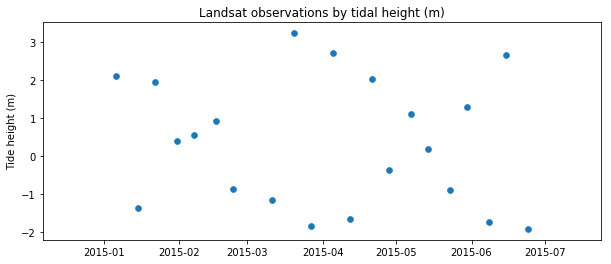

In [22]:
# Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes
tidepost_lat, tidepost_lon = -18.2066466248, 122.214634558

# The OTPS model requires inputs as 'TimePoint' objects, which are combinations of lon-lat coordinates 
# and a datetime object. You can create a list of these with a list comprehension:
observed_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]

# Feed the entire list of timepoints to the OTPS `predict_tide` function:
observed_predictedtides = predict_tide(observed_timepoints)

# For each of the predicted tide objects, extract a list of tidal heights in `m` units relative to mean 
# sea level (the `tide_m` method should not be confused with the `depth_m` method, which gives you the 
# ocean depth at the tide post location that is used by the OTPS model to predict tides)
observed_tideheights = [predictedtide.tide_m for predictedtide in observed_predictedtides]

# Create a dataframe of tidal heights for each Landsat observation
observed_df = pd.DataFrame({'tide_height': observed_tideheights}, 
                           index=pd.DatetimeIndex(observed_datetimes))
display(observed_df)

# Plot tidal heights against Landsat observation date
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(observed_df.index, observed_df.tide_height, linewidth=0.6, zorder=1, label='Modelled')
ax.set_title('Landsat observations by tidal height (m)')
ax.set_ylabel('Tide height (m)');


### Tagging, filtering and compositing Landsat observations by tidal height/stage
Adds tidal height data back into our original `xarray` dataset so that each Landsat observation is correctly tagged with its corresponding tidal height. Tagged images can then be filtered or composited to study characteristics of the coastline at various tidal stages.

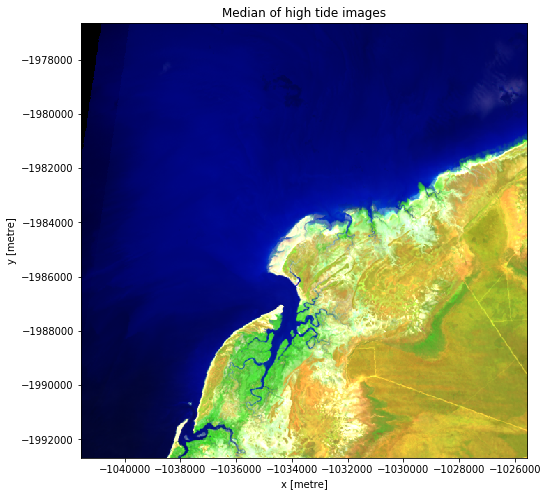

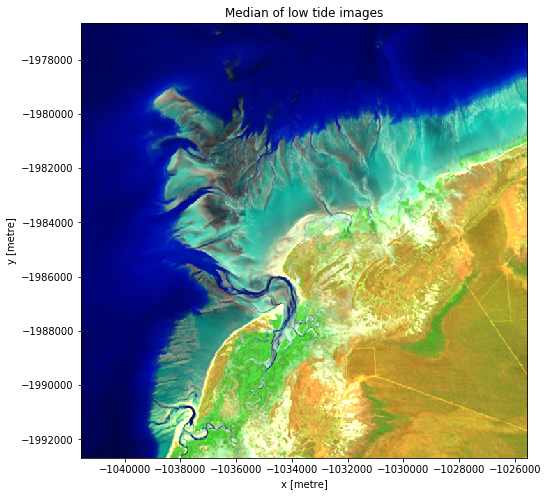

In [24]:
# Tag each of our Landsat observations with its matching tide height by creating a new xarray dataset 
# using our tide heights and observation times, and then combining this with our original dataset. 
# This ensures that tide heights are correctly associated with the time dimension of the xarray dataset
data['tide_heights'] = xr.DataArray(observed_tideheights, [('time', data.time)])

# To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
# imagery, we can compute the lowest 20th and highest 80th percentile tide heights, and use these to 
# filter our observations:
low_height, high_height = np.percentile(data.tide_heights, [20, 80])
filtered_high = data.where(data.tide_heights > high_height, drop = True)
filtered_low = data.where(data.tide_heights < low_height, drop = True)

# Take the simple median of each set of low and high tide observations to produce a composite. 
# (Alternatively, observations could be combined using a geomedian to keep band relationships consistent)
median_high = filtered_high.median(dim = 'time', keep_attrs = True)
median_low = filtered_low.median(dim = 'time', keep_attrs = True)

# Plot the resulting low and high tide composites in false-color
median_high[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))
plt.title('Median of high tide images')
median_low[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))
plt.title('Median of low tide images');


## Ebb and flow tidal phases
By comparing tide heights 15 minutes before the before and after the observed Landsat observation, we can determine whether the tide was rising (flow tide) or falling (ebb tide):

In [25]:
# Model tides 15 minutes before each Landsat observation:
td = timedelta(minutes=15)
preobs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt - td) for dt in observed_datetimes]
preobs_predictedtides = predict_tide(preobs_timepoints)
preobs_tideheights = [predictedtide.tide_m for predictedtide in preobs_predictedtides]

# Now compute tides for 15 minutes after the observation:
postobs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt + td) for dt in observed_datetimes]
postobs_predictedtides = predict_tide(postobs_timepoints)
postobs_tideheights = [predictedtide.tide_m for predictedtide in postobs_predictedtides]

# Compare the two tide heights: if the tides decrease over the 30 minute period the tide is "ebbing"; 
# if it increases the tide is "flowing"
observed_phase = ["Flow" if (pre > post) else "Ebb" for (pre, post) in 
                  zip(preobs_tideheights, postobs_tideheights)]

# Add phase to datatrame of Landsat observations
observed_df['phase'] = observed_phase
display(observed_df)


,tide_height,phase
2015-01-06 01:55:20,2.093,Ebb
2015-01-15 01:49:32,-1.355,Flow
2015-01-22 01:55:15,1.947,Ebb
2015-01-31 01:49:27,0.392,Flow
2015-02-07 01:55:12,0.563,Ebb
2015-02-16 01:49:19,0.918,Flow
2015-02-23 01:55:05,-0.874,Ebb
2015-03-11 01:54:55,-1.164,Ebb
2015-03-20 01:49:05,3.243,Ebb
2015-03-27 01:54:47,-1.848,Ebb


### Ebb and flow tide composites
Using tidal phase data, we can also create composites of the landscape during falling and rising tides. This may be particularly useful in environments like large tidal flats or mangrove forests where water may remain in the landscape for considerable time after the tidal peak.

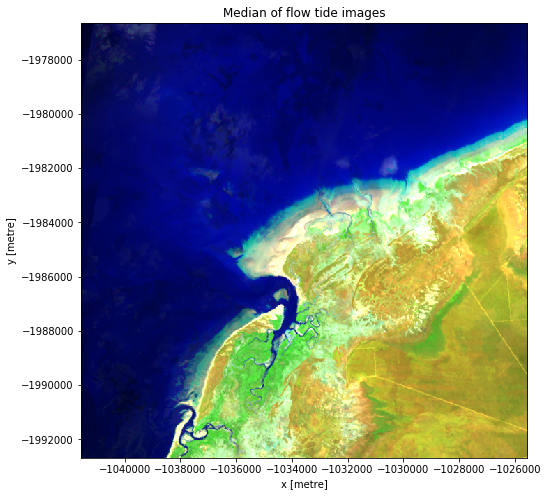

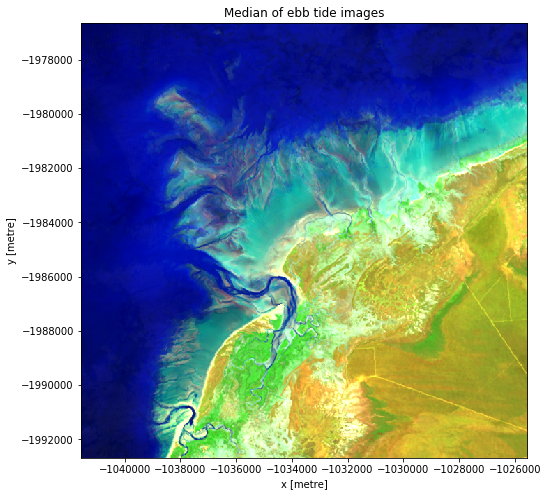

In [26]:
# Add back into 
data['tide_phase'] = xr.DataArray(observed_phase, [('time', data.time)])

# To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
# imagery, we can compute the lowest 20th and highest 80th percentile tide heights, and use these 
# to filter our observations:
filtered_flow = data.where(data.tide_phase == 'Flow', drop = True)
filtered_ebb = data.where(data.tide_phase == 'Ebb', drop = True)

# Take the median of each set of low and high tide observations to produce a composite:
median_flow = filtered_flow.median(dim = 'time', keep_attrs = True)
median_ebb = filtered_ebb.median(dim = 'time', keep_attrs = True)

# Plot the resulting low and high tide composites in false-color:
median_flow[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))
plt.title('Median of flow tide images')
median_ebb[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))
plt.title('Median of ebb tide images');


## Advanced: computing tides without loading images first using dask
It is also possible to compute tides for satellite observations that have not yet been loaded from the datacube. To achieve this, we can use `dask`, which allows us to 'queue' up xarray operations so that we only need run our analyses *after* we have obtained a filtered subset of our data.

If you are only interested in a small number of images with specific tidal conditions, this is likely to be far more efficient than using `dc.load` to load in an entire time series of observations first and then filtering by tide!

In [27]:
# Return observations that match our query without actually loading them using dask. If you inspect the 
# arrays contained inside the new xarray dataset, you will see that it is made up of `dask.array` arrays.
# These are not actually loaded into memory, but we can still apply xarray functions to them like
# normal before finally running all our operations in one go using the `.compute()` method
data = dc.load(product = "ls8_nbart_albers", group_by = 'solar_day', dask_chunks={'time': 1}, **query)

# We can extract dates for each observation like normal:
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()

# Use the tidal mode to extract tide heights for each observation:
test_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]
test_predictedtides = predict_tide(test_timepoints)
test_tideheights = [predictedtide.tide_m for predictedtide in test_predictedtides]

# Assign these tide heights back into the dataset:
data['tide_heights'] = xr.DataArray(test_tideheights, [('time', data.time)])

# As before, filter out all but the lowest 20th percentile tide heights:
low_height = np.percentile(data.tide_heights, [20])
filtered_low = data.where(data.tide_heights < low_height, drop = True)
print(filtered_low)


<xarray.Dataset>
Dimensions:          (time: 4, x: 641, y: 641)
Coordinates:
  * time             (time) datetime64[ns] 2015-03-27T01:54:47 ...
  * y                (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x                (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 -1.041e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=(1, 641, 641)>
    blue             (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=(1, 641, 641)>
    green            (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=(1, 641, 641)>
    red              (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=(1, 641, 641)>
    nir              (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=(1, 641, 641)>
    swir1            (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=(1, 641, 641)>
    swir2            (time, y, x) float64 dask.array<shape=(4, 641, 641), chunksize=

### Loading and compositing filtered subset of observations
Up to this point, none of our operations have actually been run: `dask` has simply stacked them up in a queue while it waits for us to run the `compute()` method. When we do this, dask will load in only our filtered subset of data, which significantly decreases processing speed:


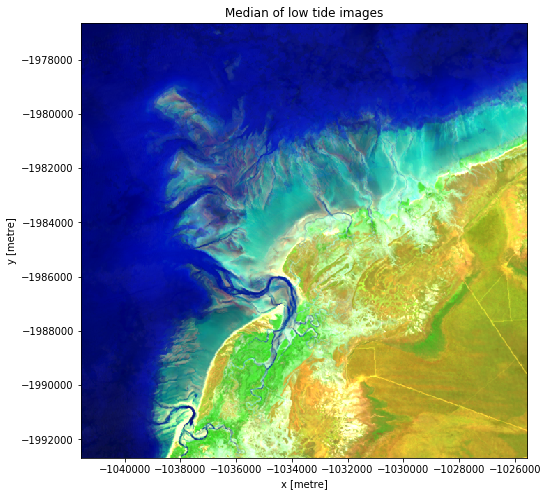

In [28]:
# Run `compute()` to load only our filtered datasets:
filtered_low = filtered_low.compute()

# Now we can take the median of each set of low and high tide observations to produce a composite:
median_low = filtered_low.median(dim = 'time', keep_attrs = True)

# The result should be identical to the low-tide composite we produced earlier, despite taking 
# only a fraction of the time to process:
median_ebb[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))
plt.title('Median of low tide images');
